In [121]:
import requests
from bs4 import BeautifulSoup
import geocoder # import geocoder

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Setup the web scraping object 

In [8]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")

#### Scarpe the web for the neighborhood information

In [9]:
table=soup.find('table')
table_contents=[]

for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        # row.span.text is in this format: 'North York(Parkwoods)', we need to extract 'Parkwoods' out of it
        raw_text = row.span.text
        cell['Neighborhood'] = raw_text[raw_text.index('(')+1:raw_text.index(')')].replace(' / ', ', ')
        table_contents.append(cell)

#### Create the dataframe that holds all the information

In [10]:
toronto_neighborhood_df = pd.DataFrame(table_contents)
toronto_neighborhood_df['Borough']=toronto_neighborhood_df['Borough'].replace(
    {'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
     'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
     'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
     'MississaugaCanada Post Gateway Processing Centre':'Mississauga'}
)
toronto_neighborhood_df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


#### Check for not assigned neighborhood

In [11]:
not_assigned_neighborhood = toronto_neighborhood_df[toronto_neighborhood_df['Neighborhood'] == 'Not assigned']
print('There are {} unassigned neighborhood(s)'.format(len(not_assigned_neighborhood)))

There are 0 unassigned neighborhood(s)


In [12]:
print('Shape of the result dataframe: {}'.format(toronto_neighborhood_df.shape))

Shape of the result dataframe: (103, 3)


#### Now we have a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. 

In [40]:
geospatial_coord = pd.read_csv('Geospatial_Coordinates.csv')

result = pd.merge(toronto_neighborhood_df, geospatial_coord, left_on = 'PostalCode', right_on = 'Postal Code')
result.drop(['Postal Code'], axis=1, inplace=True)
result

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


#### work with only boroughs that contain the word "Toronto"

In [47]:
df_toronto = result[result['Borough'].str.contains('Toronto')].reset_index(drop=True)
df_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
8,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259
9,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106


#### Get the coordinates of Toronto

In [51]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [52]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude],zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials and Version

In [54]:
CLIENT_ID = 'CVF5AHLRBAPXOQHXAYVKI5NOUTMCB4Z100POAFKJMPRCA1DZ' # your Foursquare ID
CLIENT_SECRET = '0RYVSFFRB0ZXJGLGL4TSSC0XVTZTHLJFJKBVHC0NCVO03UQQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [55]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('Working with neightborhood {}'.format(name))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [56]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                 latitudes=df_toronto['Latitude'],
                                 longitudes=df_toronto['Longitude'])

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Enclave of M5E
St. James Town, Cabbagetown
First Canadi

In [62]:
print('There are total of {} results'.format(len(toronto_venues)))
toronto_venues.head()

There are total of 1605 results


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


#### Analyze Each Neighborhood

In [90]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# Since there are categories with name 'Neighborhood' toronto_venues dataframe, we should use another name
toronto_onehot.insert(0, 'Neighborhood Name', toronto_venues['Neighborhood'])

toronto_onehot.head()

,Neighborhood Name,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [91]:
print('Shape of onehot encoded dataframe is {}'.format(toronto_onehot.shape))

Shape of onehot encoded dataframe is (1605, 231)


#### group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [110]:
toronto_grouped = toronto_onehot.groupby('Neighborhood Name').mean().reset_index()
toronto_grouped.head()

,Neighborhood Name,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.017241,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.017241,0.051724,0.0,0.000000,0.0,0.017241,0.017241,0.0,0.034483,0.0,0.0,0.017241,0.0,0.0000,0.000000,0.0000,0.0,0.017241,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.017241,0.0,0.0000,0.0,0.034483,0.0,0.0,0.0,0.00,0.017241,0.051724,0.051724,0.0,0.0,0.0,0.0,0.017241,0.000000,0.017241,0.00,0.0,0.0,0.017241,0.0,0.0,0.0,0.000000,0.017241,0.000000,0.0,0.017241,0.000000,0.0,0.0,0.0,0.000000,0.0,0.017241,0.0,0.0,0.0,0.0,0.000000,0.034483,0.0,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.0,0.017241,0.017241,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.017241,0.017241,0.017241,0.00,0.00000

#### create the new dataframe and display the top 10 venues for each neighborhood.

In [103]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [104]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood Name'] = toronto_grouped['Neighborhood Name']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Cocktail Bar,Bakery,Coffee Shop,Pub,Restaurant,Pharmacy,Seafood Restaurant,Farmers Market,Beer Bar,Cheese Shop
1,"Brockton, Parkdale Village, Exhibition Place",Café,Performing Arts Venue,Breakfast Spot,Coffee Shop,Yoga Studio,Grocery Store,Pet Store,Nightclub,Music Venue,Italian Restaurant
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Airport,Harbor / Marina,Plane,Coffee Shop,Sculpture Garden,Boat or Ferry,Boutique
3,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Bubble Tea Shop,Restaurant,Japanese Restaurant,Burger Joint,Yoga Studio
4,Christie,Grocery Store,Café,Park,Coffee Shop,Italian Restaurant,Candy Store,Restaurant,Athletics & Sports,Baby Store,Nightclub


#### Decide best k for k-means

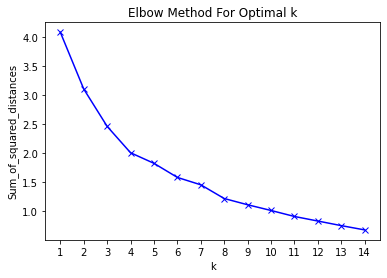

In [124]:
sum_of_squared_distances = []
kclusters = range(1,15)

for k in kclusters:
    clutering_result = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
    sum_of_squared_distances.append(clutering_result.inertia_)

plt.plot(kclusters, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.xticks(kclusters)
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Choose k=8 according to the elbow plot

In [127]:
# set number of clusters
kclusters = 8

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood Name', axis=1)

# run k-means clustering
clutering_result = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
clutering_result.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 4, 1, 2,
       1, 1, 1, 1, 7, 5, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1])

#### create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [131]:
neighborhoods_venues_sorted['Cluster Label'] = clutering_result.labels_

toronto_cluster_result = pd.merge(neighborhoods_venues_sorted, df_toronto, left_on='Neighborhood Name', right_on='Neighborhood')

In [145]:
toronto_cluster_result

,Neighborhood Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster,Cluster Label,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,Berczy Park,Cocktail Bar,Bakery,Coffee Shop,Pub,Restaurant,Pharmacy,Seafood Restaurant,Farmers Market,Beer Bar,Cheese Shop,1,1,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
1,"Brockton, Parkdale Village, Exhibition Place",Café,Performing Arts Venue,Breakfast Spot,Coffee Shop,Yoga Studio,Grocery Store,Pet Store,Nightclub,Music Venue,Italian Restaurant,1,1,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Airport,Harbor / Marina,Plane,Coffee Shop,Sculpture Garden,Boat or Ferry,Boutique,1,1,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420
3,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Bubble Tea Shop,Restaurant,Japanese Restaurant,Burger Joint,Yoga Studio,1,1,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
4,Christie,Grocery Store,Café,Park,Coffee Shop,Italian Restaurant,Candy Store,Restaurant,Athletics & Sports,Baby Store,Nightclub,1,1,M6G,Downtown Toronto,Christie,43.669542,-79.422564
5,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Yoga Studio,Pub,Fast Food Restaurant,Hotel,Café,1,1,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
6,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Café,Hotel,Gym,Deli / Bodega,Italian Restaurant,Bakery,Japanese Restaurant,Seafood Restaurant,1,1,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817
7,Davisville,Café,Dessert Shop,Sandwich Place,Pizza Place,Gym,Italian Restaurant,Coffee Shop,Sushi Restaurant,Pharmacy,Seafood Restaurant,1,1,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,Davisville North,Gym,Sandwich Place,Park,Gym / Fitness Center,Breakfast Spot,Pizza Place,Department Store,Hotel,Food & Drink Shop,Distribution Center,1,1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
9,"Dufferin, Dovercourt Village",Pharmacy,Bakery,Music Venue,Bank,Middle Eastern Restaurant,Café,Bar,Supermarket,Pet Store,Park,1,1,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259


In [146]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_cluster_result['Latitude'], toronto_cluster_result['Longitude'], toronto_cluster_result['Neighborhood'], toronto_cluster_result['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters